# Denoising Example

In [1]:
using NBInclude
using Plots
@nbinclude("GPUFilterBanks.ipynb");
@nbinclude("AudioTools.ipynb");

In [2]:
tetris = load("tetris_piano_mono.wav");
fs = round(Int,tetris.samplerate);
original = audio_to_float( truncate_audio(tetris.data,nextpow(2,10*fs)) );
noisy = original .+ Float32.(0.01*randn(size(original)));

In [3]:
float_to_audio(original,fs)

524288-frame, 1-channel SampleBuf{Q0f15, 1}
11.888616780045352s sampled at 44100.0Hz
▁▆▆▅▄▅▅▆▆▆▆▆▆▆▆▅▆▅▆▅▅▅▅▅▆▅▆▅▄▃▅▅▆▅▆▅▅▅▄▄▅▅▆▅▅▄▆▅▄▄▅▅▅▅▆▅▅▅▅▅▅▅▄▄▄▃▃▁▅▅▅▄▆▅▆▅▄▄▆▅

In [4]:
float_to_audio(noisy,fs)

524288-frame, 1-channel SampleBuf{Q0f15, 1}
11.888616780045352s sampled at 44100.0Hz
▄▆▆▅▅▅▆▆▆▆▆▆▆▆▆▅▆▅▆▅▅▅▆▅▆▅▆▅▅▄▅▅▆▅▆▅▅▅▅▅▅▅▆▅▅▅▆▅▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▄▄▄▆▅▅▅▆▆▆▅▅▄▆▆

In [5]:
num_octaves = 10;

filters = [
    WT.makeqmfpair(wavelet(WT.haar)),
    WT.makereverseqmfpair(wavelet(WT.haar))
];
LA = tensor(Float32.(filters[1][1]));
HA = tensor(Float32.(filters[1][2]));
LS = tensor(Float32.(filters[2][1]));
HS = tensor(Float32.(filters[2][2]));

x = [tensor(original)];

size.(x)

1-element Vector{NTuple{4, Int64}}:
 (524288, 1, 1, 1)

In [6]:
y = analysis_filterbank(x, LA, HA)
size.(y)

11-element Vector{NTuple{4, Int64}}:
 (8192, 32, 1, 1)
 (4096, 32, 1, 1)
 (2048, 32, 1, 1)
 (1024, 32, 1, 1)
 (512, 32, 1, 1)
 (256, 32, 1, 1)
 (128, 32, 1, 1)
 (64, 32, 1, 1)
 (32, 32, 1, 1)
 (16, 32, 1, 1)
 (16, 32, 1, 1)

In [7]:
S1 = [];
S2 = [];

for octave ∈ 1:(num_octaves+1)
    y_i = collect(y[octave]);
    h = heatmap(abs.(y_i[:,:]'), 
        axis=nothing, colorbar=nothing, size=(1000,2000));
    append!(S1,[h]);
    
    threshold = CuArray(
        fill(Float32(0.2*(2.0^-octave)),
            size(y[octave])
            )
        );
    
    y[octave] .= y[octave] .* Float32.( abs.(y[octave]) .> threshold)
    
    y_i = collect(y[octave]);
    h = heatmap(abs.(y_i[:,:]'),
        axis=nothing, colorbar=nothing, size=(1000,2000));
    append!(S2,[h]);
end

In [8]:
x = synthesis_filterbank(y, LS, HS)
size.(x)

1-element Vector{NTuple{4, Int64}}:
 (524288, 1, 1, 1)

In [9]:
float_to_audio(collect(x[1][:]),fs)

524288-frame, 1-channel SampleBuf{Q0f15, 1}
11.888616780045352s sampled at 44100.0Hz
▁▆▆▅▄▅▅▆▆▆▆▆▆▆▆▅▆▅▆▅▅▅▅▅▆▅▆▅▄▄▅▅▆▅▆▅▅▅▄▄▅▅▆▅▅▄▆▅▄▄▅▅▅▅▆▅▅▅▅▅▅▅▄▄▄▃▃▁▅▅▅▄▆▅▆▅▄▄▆▅

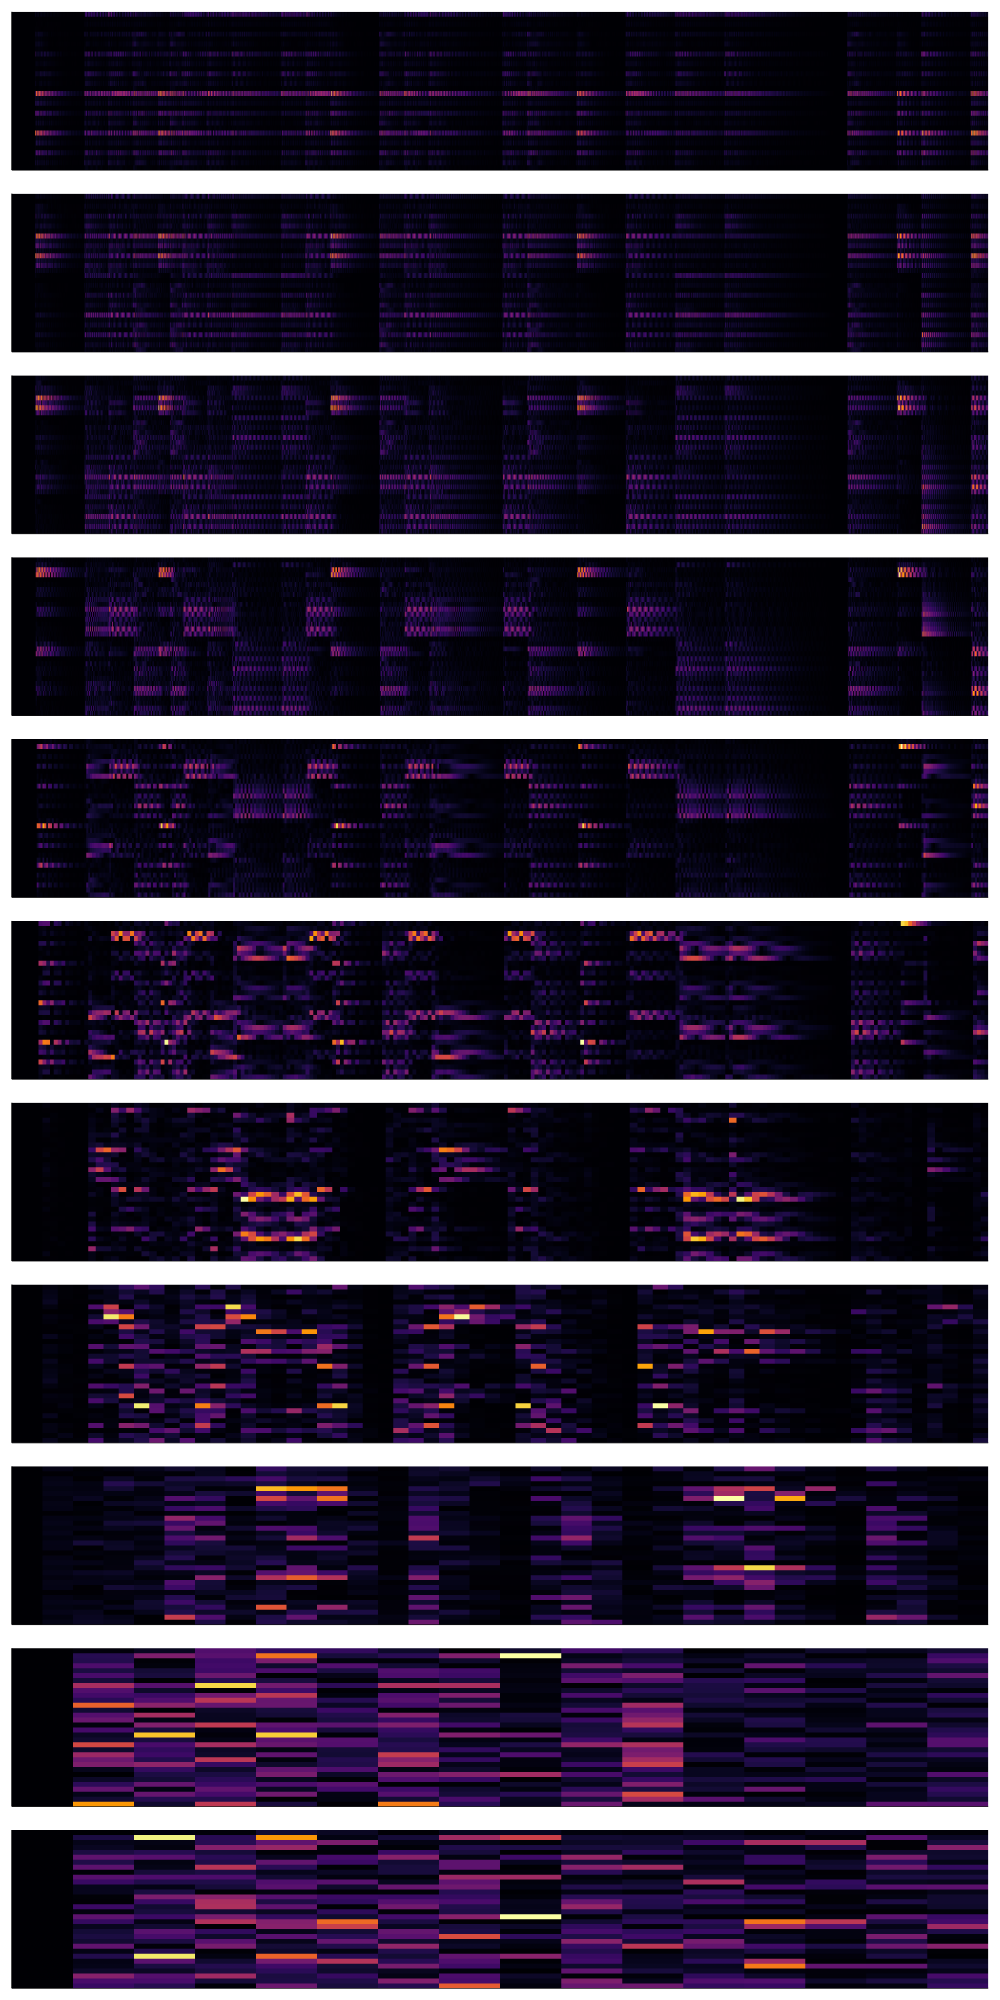

In [10]:
l = @layout [p1;p2;p3;p4;p5;p6;p7;p8;p9;p10;p11];
plot(S1..., layout=l)

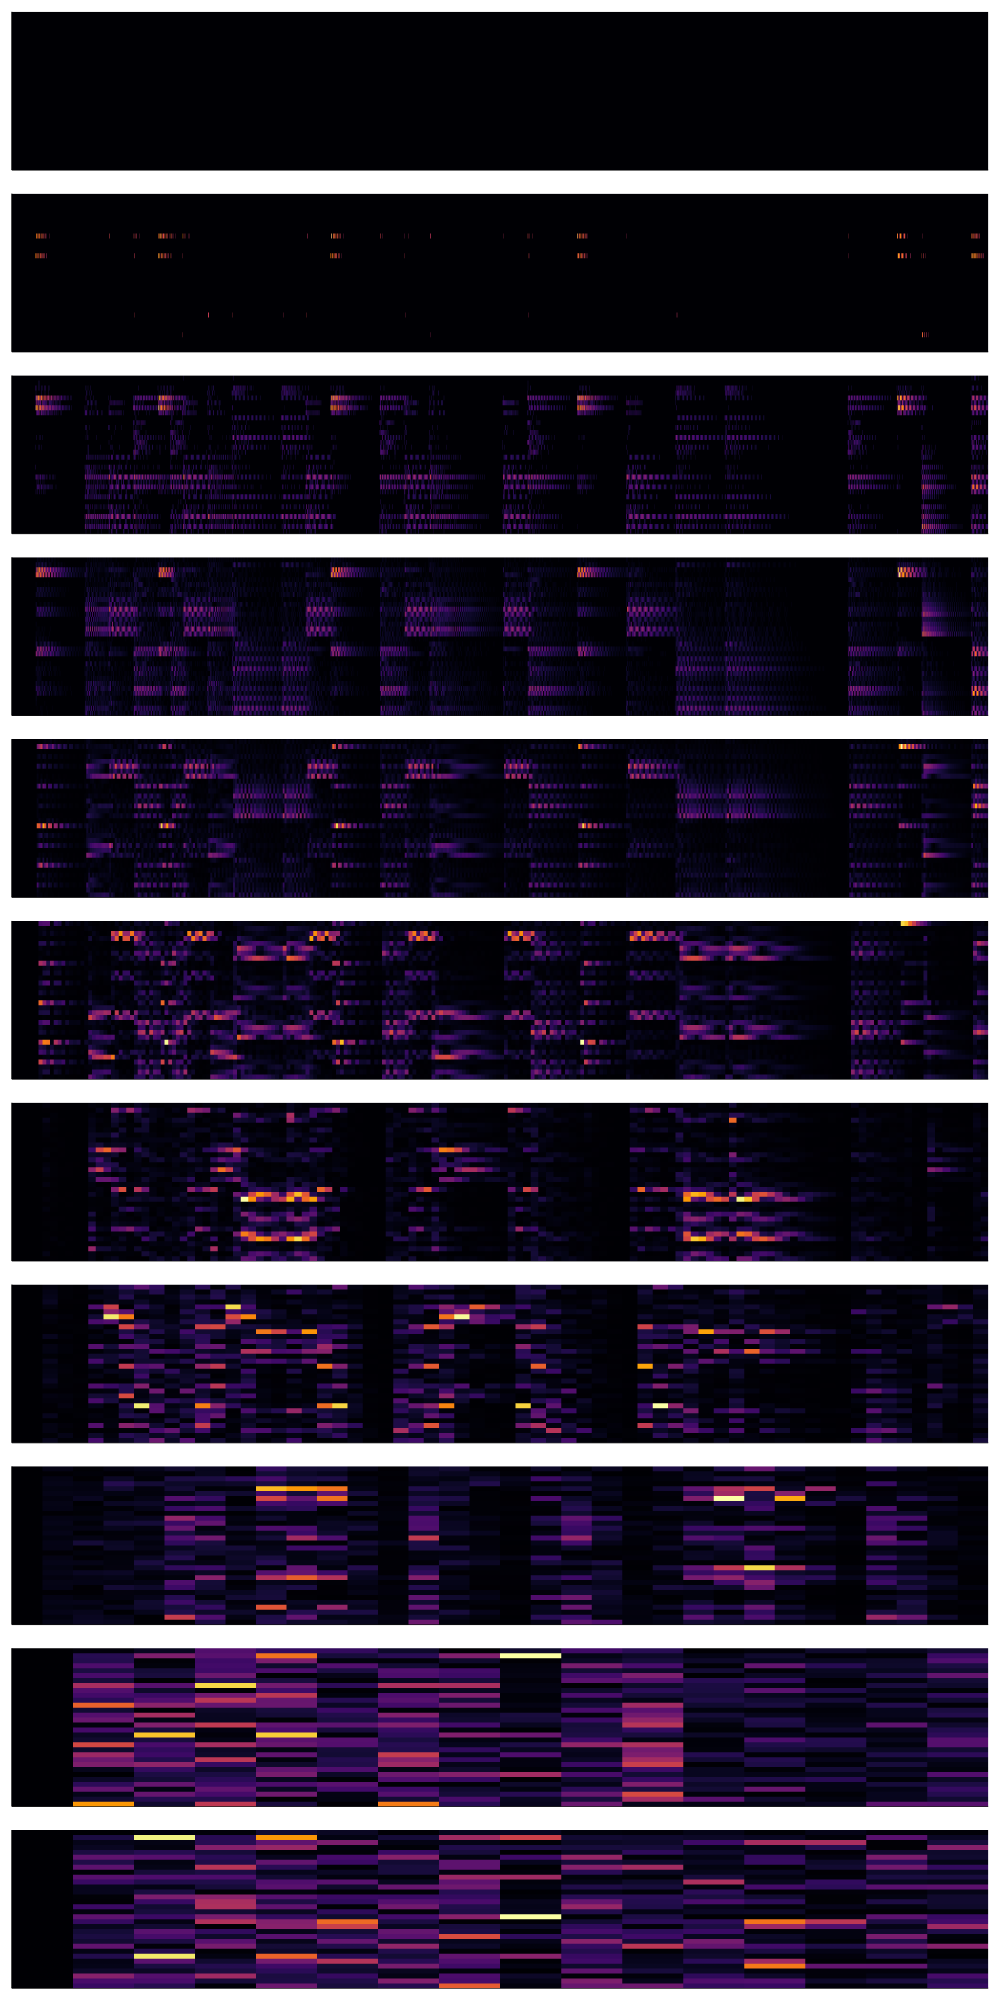

In [11]:
l = @layout [p1;p2;p3;p4;p5;p6;p7;p8;p9;p10;p11];
plot(S2..., layout=l)